## Assignment 12

In [1]:
import numpy as np
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Conv2D, Flatten, Dense, Input, Lambda, Reshape, Conv2DTranspose, Layer
from keras import metrics
from keras import backend as K
K.clear_session()
import tensorflow._api.v2.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

input_img = Input(shape=img_shape)

x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

shape_before_flattening = K.int_shape(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)

z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

In [3]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

In [4]:
decoder_input = Input(K.int_shape(z)[1:])


x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = Reshape(shape_before_flattening[1:])(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2D(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)

z_decoded = decoder(z)

In [5]:
class CustomVariationalLayer(Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

y = CustomVariationalLayer()([input_img, z_decoded])

In [6]:
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None, shuffle=True, epochs=10, batch_size=batch_size, validation_data=(x_test, None))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_1[0][0]']               
                                                                                            

c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 386s 6ms/sample - loss: 28258708.3586 - val_loss: 0.2024
Epoch 2/10
60000/60000 [==============================] - 386s 6ms/sample - loss: 0.1971 - val_loss: 0.1929
Epoch 3/10
60000/60000 [==============================] - 382s 6ms/sample - loss: 0.1914 - val_loss: 0.1897
Epoch 4/10
60000/60000 [==============================] - 398s 7ms/sample - loss: 0.1884 - val_loss: 0.1877
Epoch 5/10
60000/60000 [==============================] - 385s 6ms/sample - loss: 0.1864 - val_loss: 0.1885
Epoch 6/10
60000/60000 [==============================] - 395s 7ms/sample - loss: 0.1850 - val_loss: 0.1838
Epoch 7/10
60000/60000 [==============================] - 406s 7ms/sample - loss: 0.1839 - val_loss: 0.1834
Epoch 8/10
60000/60000 [==============================] - 409s 7ms/sample - loss: 0.1831 - val_loss: 0.1820
Epoch 9/10
60000/60000 [==============================] - 419s 7ms/sample - loss: 0.1824 - val_loss: 0.1815
Epoch 10/10
60000/60000 [=======

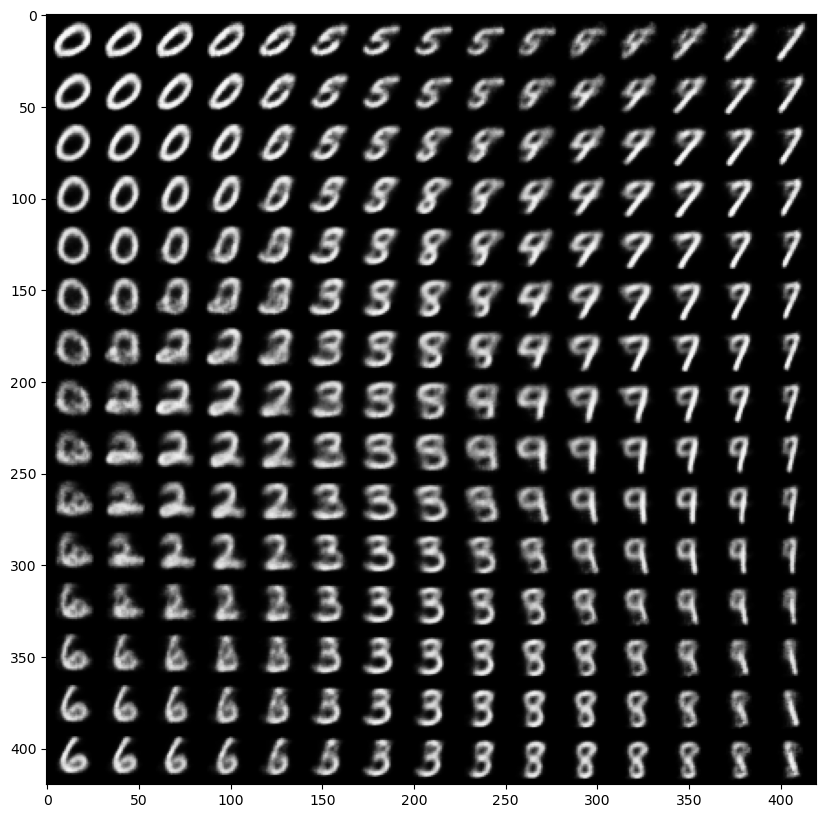

In [13]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import os 
filepath = 'results/vae/'
file = "MNIST_VAE_grid.png"
if not os.path.exists(filepath):
    os.makedirs(filepath)

n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.savefig(os.path.join(filepath, file))
plt.show()